In [1]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:3000]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'author', 'title', 'style', 'description']


In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 1083/1083 [00:13<00:00, 79.36it/s]


In [4]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4685, 0.3801, 0.3472])
Std of the image: tensor([0.2129, 0.1872, 0.1589])


In [15]:
transform_img = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        row = self.dataframe.iloc[index]
        img_pil = Image.open(row['image'])
        img_pil = img_pil.convert('RGB')
        img_normalized = transform_img(img_pil)
        return(img_normalized,row['description'])

dataset = ArtDataset(data)

d = random_split(dataset,[0.8,0.2],generator=torch.Generator().manual_seed(42))
train_dataset, val_dataset = d[0],d[1]


C:\Users\Fede\AppData\Local\Temp\ipykernel_21684\1469822906.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: 32


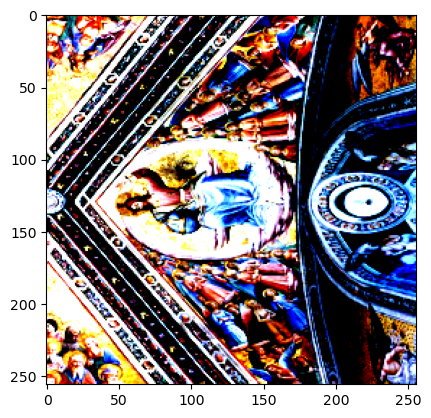

Author: In the summer of 1447 Fra Angelico, assisted by Benozzo Gozzoli and several other minor artists, had painted a fresco of the Prophets in one of the triangular ceiling vaults and Christ the Judge in another in the Chapel of San Brizio, a large Gothic construction built around 1408 in the Orvieto Cathedral. The remaining sections of the ceiling werepainted by Luca Signorelliin 1499-1502.In the centre of the quadrant above the altar, Christ proffers the globe of the universe as he raises his right hand to summon the dead from their graves. Seated upon banks of clouds against a golden background, he radiates a gilded aureole of light, the scintillating rays of which illuminate the faces and garments of the seraphim surrounding him.


In [16]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img.T)
plt.show()
print(f"Author: {label}")

In [30]:
#Define CNN to extract features from images
class CNN(nn.Module):
    def __init__(self, embed_size):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.fc = nn.Linear(512*17*17,embed_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,images):
        x = self.pool1(self.relu1(self.conv1(images)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

#Define RNN to extract features from descriptions
class RNN(nn.Module):
    def __init__(self,vocab_size,embed_size,hidden_size,num_layers):
        super(RNN,self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,embed_size)

    def forward(self,features,descriptions):
        embeddings = self.embed(descriptions.long())
        embeddings = torch.cat((features.unsqueeze(1),embeddings),1)
        hiddens,_ = self.lstm(embeddings)
        outputs = self.fc(hiddens)
        return outputs
    
#Combine into an EncoderDecoder Model
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size,hidden_size, vocab_size, num_layers):
        super(EncoderDecoder,self).__init__()
        self.encoder = CNN(embed_size)
        self.decoder = RNN(vocab_size,embed_size,hidden_size,num_layers)
    def forward(self,images,descriptions):
        features = self.encoder(images)
        outputs = self.decoder(features,descriptions)
        return outputs


In [31]:
#Define the loss function
class Loss(nn.Module):
    def __init__(self):
        super(Loss,self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self,outputs,targets):
        outputs = outputs[:,:-1,:].contiguous().view(-1,outputs.size(2))
        targets = targets[:,1:].contiguous().view(-1)
        return self.cross_entropy(outputs,targets)

In [32]:
#Define the training function
def train(trainloader,encoderdecoder,loss_fn,optimizer,epochs=1):
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            images, descriptions = data[0].to(device), data[0][:-1].to(device)
            outputs = encoderdecoder(images,descriptions)
            loss = loss_fn(outputs,descriptions)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')

In [33]:
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [34]:
loss_fn = Loss()
encoderdecoder = EncoderDecoder(embed_size=256,hidden_size=512,vocab_size=10000,num_layers=3)
optimizer = optim.Adam(encoderdecoder.parameters(),lr=0.001)
train(trainloader,encoderdecoder,loss_fn,optimizer,epochs=20)

IndexError: index out of range in self

In [15]:
#Define the evaluation function
def evaluate(valloader,encoderdecoder, loss_fn):
    for i, (images,descriptions) in enumerate(valloader):
        images = images.to(device)
        descriptions = descriptions.to(device)
        outputs = encoderdecoder(images,descriptions)
        loss = loss_fn(outputs,descriptions)
        if i % 100 == 0:
            print(f'Batch: {i}, Loss: {loss.item()}')

In [16]:
#Define the prediction function
def predict(encoderdecoder,image):
    image = image.to(device)
    feature = encoderdecoder.encoder(image).unsqueeze(1)
    sampled_ids = []
    states = None
    for i in range(20):
        hiddens,states = encoderdecoder.decoder.lstm(feature,states)
        outputs = encoderdecoder.decoder.fc(hiddens.squeeze(1))
        predicted = outputs.max(1)[1]
        sampled_ids.append(predicted)
        feature = encoderdecoder.decoder.embed(predicted)
        feature = feature.unsqueeze(1)
    sampled_ids = torch.stack(sampled_ids,1)
    sampled_ids = sampled_ids[0].cpu().numpy()
    return sampled_ids

In [18]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [19]:
#Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [20]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image,caption):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(caption)
    plt.show()